# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

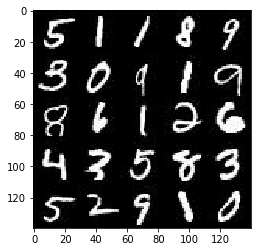

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

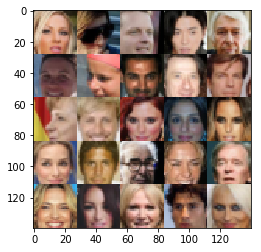

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate',shape=())
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.15
        x1 = tf.layers.conv2d(images, 64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim,5,strides=2,padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sampels, losses = [],[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #batch_images = batch_images * 2
                steps += 1
                
                # Real image input for discriminator
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2],data_shape[3])
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), 
                           "Discriminator Loss: {:4f}...".format(train_loss_d),
                           "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after trainig
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3],data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.472063... Generator Loss: 1.1895
Epoch 1/2... Discriminator Loss: 0.485425... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 0.483931... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 0.347468... Generator Loss: 1.7418
Epoch 1/2... Discriminator Loss: 2.653687... Generator Loss: 6.0586
Epoch 1/2... Discriminator Loss: 0.432016... Generator Loss: 1.6838
Epoch 1/2... Discriminator Loss: 1.051455... Generator Loss: 0.5808
Epoch 1/2... Discriminator Loss: 0.736694... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 0.556015... Generator Loss: 1.2833
Epoch 1/2... Discriminator Loss: 0.887968... Generator Loss: 0.7134


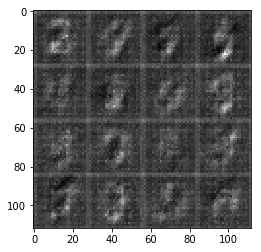

Epoch 1/2... Discriminator Loss: 1.018147... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 0.544642... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 1.805158... Generator Loss: 0.2303
Epoch 1/2... Discriminator Loss: 0.861131... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 0.973192... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 0.835369... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.003137... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 0.858959... Generator Loss: 0.6897
Epoch 1/2... Discriminator Loss: 0.955883... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 0.633246... Generator Loss: 1.0319


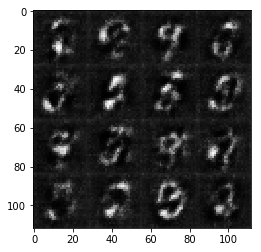

Epoch 1/2... Discriminator Loss: 1.212687... Generator Loss: 0.4455
Epoch 1/2... Discriminator Loss: 0.829880... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 0.833482... Generator Loss: 0.7175
Epoch 1/2... Discriminator Loss: 0.832969... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 0.965850... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 0.785223... Generator Loss: 0.7787
Epoch 1/2... Discriminator Loss: 0.699307... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 0.820490... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 0.496677... Generator Loss: 1.2618
Epoch 1/2... Discriminator Loss: 0.819340... Generator Loss: 0.7350


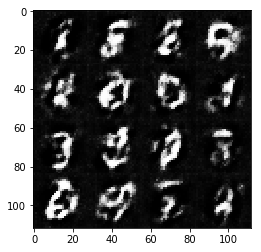

Epoch 1/2... Discriminator Loss: 0.652252... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 0.500514... Generator Loss: 1.2555
Epoch 1/2... Discriminator Loss: 0.864868... Generator Loss: 0.6833
Epoch 1/2... Discriminator Loss: 0.731728... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 0.826891... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 0.445054... Generator Loss: 1.6520
Epoch 1/2... Discriminator Loss: 0.595835... Generator Loss: 2.5870
Epoch 1/2... Discriminator Loss: 0.638356... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 0.447612... Generator Loss: 1.4307
Epoch 1/2... Discriminator Loss: 0.386317... Generator Loss: 2.0394


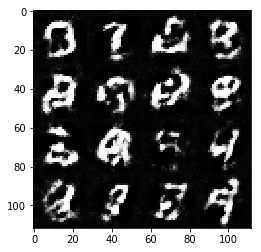

Epoch 1/2... Discriminator Loss: 0.871062... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 0.411856... Generator Loss: 1.9755
Epoch 1/2... Discriminator Loss: 0.392348... Generator Loss: 1.8490
Epoch 1/2... Discriminator Loss: 0.631839... Generator Loss: 2.6847
Epoch 1/2... Discriminator Loss: 0.452143... Generator Loss: 2.7251
Epoch 1/2... Discriminator Loss: 0.411993... Generator Loss: 1.7613
Epoch 2/2... Discriminator Loss: 0.770434... Generator Loss: 3.4563
Epoch 2/2... Discriminator Loss: 0.431680... Generator Loss: 1.7215
Epoch 2/2... Discriminator Loss: 0.421939... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 0.614746... Generator Loss: 1.0369


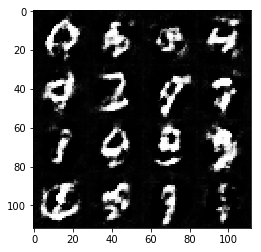

Epoch 2/2... Discriminator Loss: 1.266956... Generator Loss: 0.4160
Epoch 2/2... Discriminator Loss: 0.457872... Generator Loss: 1.4545
Epoch 2/2... Discriminator Loss: 0.440835... Generator Loss: 2.1391
Epoch 2/2... Discriminator Loss: 0.566993... Generator Loss: 2.5255
Epoch 2/2... Discriminator Loss: 0.982630... Generator Loss: 3.4250
Epoch 2/2... Discriminator Loss: 0.404290... Generator Loss: 2.0055
Epoch 2/2... Discriminator Loss: 0.672844... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 0.793496... Generator Loss: 0.8431
Epoch 2/2... Discriminator Loss: 0.457055... Generator Loss: 1.5950
Epoch 2/2... Discriminator Loss: 0.512491... Generator Loss: 1.7128


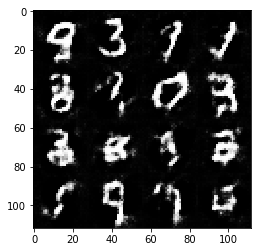

Epoch 2/2... Discriminator Loss: 0.550923... Generator Loss: 2.2141
Epoch 2/2... Discriminator Loss: 0.652323... Generator Loss: 1.0153
Epoch 2/2... Discriminator Loss: 0.558728... Generator Loss: 1.1931
Epoch 2/2... Discriminator Loss: 0.602247... Generator Loss: 1.0454
Epoch 2/2... Discriminator Loss: 0.794091... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 1.024172... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 0.782474... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 0.970296... Generator Loss: 3.0250
Epoch 2/2... Discriminator Loss: 0.536245... Generator Loss: 1.8186
Epoch 2/2... Discriminator Loss: 0.567315... Generator Loss: 1.4896


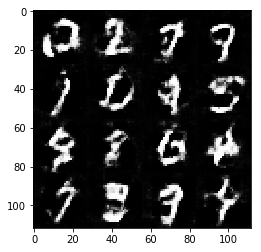

Epoch 2/2... Discriminator Loss: 0.656313... Generator Loss: 2.3614
Epoch 2/2... Discriminator Loss: 0.578010... Generator Loss: 2.0411
Epoch 2/2... Discriminator Loss: 0.519471... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 1.156790... Generator Loss: 3.2332
Epoch 2/2... Discriminator Loss: 0.604175... Generator Loss: 1.1907
Epoch 2/2... Discriminator Loss: 0.900451... Generator Loss: 2.9258
Epoch 2/2... Discriminator Loss: 0.618375... Generator Loss: 2.1664
Epoch 2/2... Discriminator Loss: 0.625959... Generator Loss: 2.4767
Epoch 2/2... Discriminator Loss: 0.654181... Generator Loss: 2.2309
Epoch 2/2... Discriminator Loss: 0.557802... Generator Loss: 2.1629


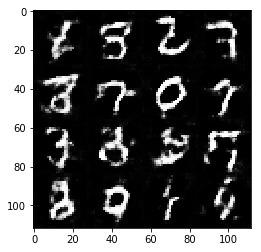

Epoch 2/2... Discriminator Loss: 0.681059... Generator Loss: 2.2262
Epoch 2/2... Discriminator Loss: 0.589515... Generator Loss: 1.8298
Epoch 2/2... Discriminator Loss: 0.582495... Generator Loss: 1.5083
Epoch 2/2... Discriminator Loss: 0.831403... Generator Loss: 2.5741
Epoch 2/2... Discriminator Loss: 0.639403... Generator Loss: 1.0865
Epoch 2/2... Discriminator Loss: 0.877812... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 0.946243... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 0.735578... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 0.618157... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 0.897587... Generator Loss: 0.6764


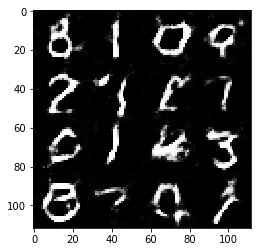

Epoch 2/2... Discriminator Loss: 0.937748... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 0.604637... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 0.680457... Generator Loss: 1.0096


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.473088... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 0.224739... Generator Loss: 2.0192
Epoch 1/1... Discriminator Loss: 0.228288... Generator Loss: 1.9637
Epoch 1/1... Discriminator Loss: 0.276263... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 0.234319... Generator Loss: 4.6220
Epoch 1/1... Discriminator Loss: 0.200059... Generator Loss: 2.4572
Epoch 1/1... Discriminator Loss: 1.026308... Generator Loss: 6.2559
Epoch 1/1... Discriminator Loss: 1.636740... Generator Loss: 4.6902
Epoch 1/1... Discriminator Loss: 0.842238... Generator Loss: 2.9937
Epoch 1/1... Discriminator Loss: 0.961214... Generator Loss: 0.6803


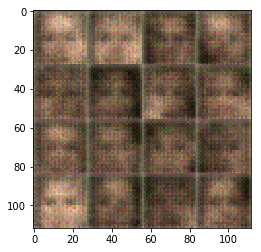

Epoch 1/1... Discriminator Loss: 0.881166... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.180488... Generator Loss: 3.7947
Epoch 1/1... Discriminator Loss: 0.730291... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 0.980723... Generator Loss: 2.7796
Epoch 1/1... Discriminator Loss: 0.823328... Generator Loss: 2.6663
Epoch 1/1... Discriminator Loss: 0.617639... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.646228... Generator Loss: 2.4551
Epoch 1/1... Discriminator Loss: 1.213174... Generator Loss: 3.2552
Epoch 1/1... Discriminator Loss: 0.673459... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.448957... Generator Loss: 0.3499


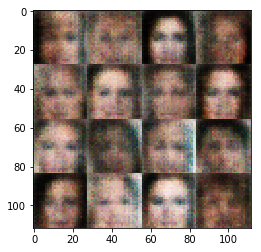

Epoch 1/1... Discriminator Loss: 0.899175... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 0.895267... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.087695... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 0.636310... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.111118... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 0.580416... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 0.589139... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 1.906313... Generator Loss: 4.2044
Epoch 1/1... Discriminator Loss: 0.471375... Generator Loss: 1.6986
Epoch 1/1... Discriminator Loss: 0.465370... Generator Loss: 1.6062


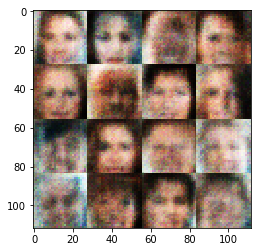

Epoch 1/1... Discriminator Loss: 0.431338... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.653743... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 0.984011... Generator Loss: 2.2782
Epoch 1/1... Discriminator Loss: 1.456429... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.080645... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 0.634352... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.651294... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.756343... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.431519... Generator Loss: 2.3422
Epoch 1/1... Discriminator Loss: 0.572911... Generator Loss: 1.2846


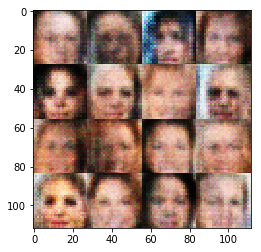

Epoch 1/1... Discriminator Loss: 0.739258... Generator Loss: 2.0796
Epoch 1/1... Discriminator Loss: 0.852438... Generator Loss: 1.5134
Epoch 1/1... Discriminator Loss: 0.842726... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 1.074965... Generator Loss: 1.8192
Epoch 1/1... Discriminator Loss: 0.900885... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 0.785353... Generator Loss: 1.6126
Epoch 1/1... Discriminator Loss: 0.853107... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.049153... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 0.940786... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 0.921688... Generator Loss: 0.8162


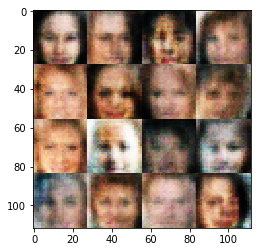

Epoch 1/1... Discriminator Loss: 0.886603... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.009700... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 1.183052... Generator Loss: 1.8036
Epoch 1/1... Discriminator Loss: 0.794027... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.981944... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 1.104333... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.112971... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.182996... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.052443... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.205439... Generator Loss: 0.4774


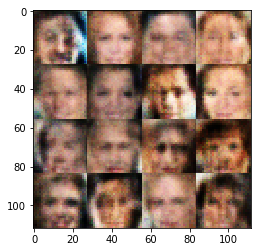

Epoch 1/1... Discriminator Loss: 0.871390... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.944953... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.160183... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 0.922593... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.227221... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 1.129760... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.052693... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.987544... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.164155... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.108984... Generator Loss: 0.5353


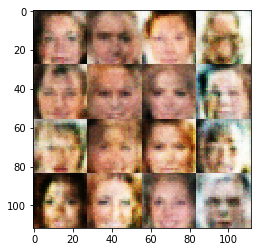

Epoch 1/1... Discriminator Loss: 0.987833... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.041401... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.856897... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 0.946612... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.033281... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 0.860247... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.198886... Generator Loss: 1.8649
Epoch 1/1... Discriminator Loss: 0.915201... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.060688... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 0.838363... Generator Loss: 0.8949


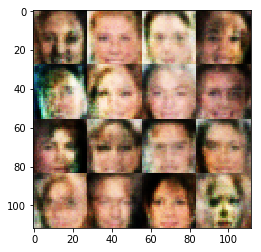

Epoch 1/1... Discriminator Loss: 1.184872... Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 0.946448... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.758282... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.091042... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 0.995470... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 0.905140... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 0.961424... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.874301... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.258738... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.961112... Generator Loss: 0.9716


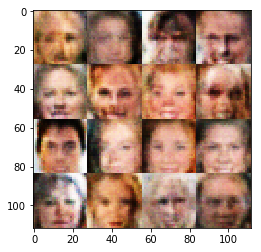

Epoch 1/1... Discriminator Loss: 0.875532... Generator Loss: 1.5028
Epoch 1/1... Discriminator Loss: 0.866340... Generator Loss: 1.5243
Epoch 1/1... Discriminator Loss: 1.209787... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 0.992618... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.911868... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.837458... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 0.952376... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 0.825580... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.996329... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 0.890981... Generator Loss: 1.1006


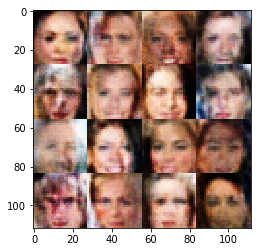

Epoch 1/1... Discriminator Loss: 0.906898... Generator Loss: 1.4267
Epoch 1/1... Discriminator Loss: 1.114307... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 0.783771... Generator Loss: 1.8585
Epoch 1/1... Discriminator Loss: 1.073754... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.000025... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 0.800129... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.878637... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.927842... Generator Loss: 1.2148
Epoch 1/1... Discriminator Loss: 0.611525... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 0.931638... Generator Loss: 1.0509


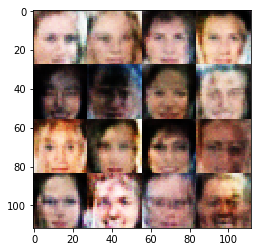

Epoch 1/1... Discriminator Loss: 0.951940... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 0.832832... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 0.536403... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 0.922335... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.880972... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.113340... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 0.805486... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.806257... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.501568... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 0.882003... Generator Loss: 0.9208


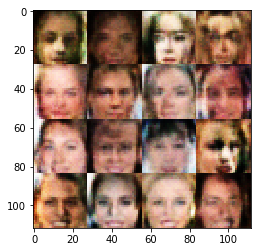

Epoch 1/1... Discriminator Loss: 1.004252... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 0.886826... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.612599... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 0.678717... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.280160... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 0.974286... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 0.804366... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 0.987986... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.280892... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 0.852456... Generator Loss: 1.0523


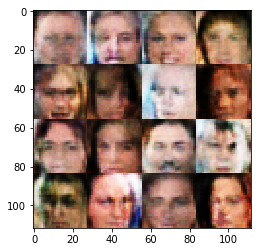

Epoch 1/1... Discriminator Loss: 1.145504... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.113777... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.730199... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 1.046587... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 0.680414... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.293709... Generator Loss: 1.8688
Epoch 1/1... Discriminator Loss: 0.879286... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 0.945840... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.822887... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 0.824923... Generator Loss: 0.9706


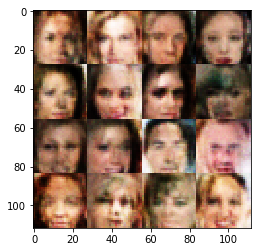

Epoch 1/1... Discriminator Loss: 0.955060... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.135896... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 0.748338... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 0.776978... Generator Loss: 2.3470
Epoch 1/1... Discriminator Loss: 0.887953... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 1.353573... Generator Loss: 2.3768
Epoch 1/1... Discriminator Loss: 1.037129... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 0.640265... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.863459... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.333255... Generator Loss: 2.6602


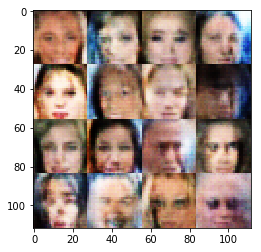

Epoch 1/1... Discriminator Loss: 0.680341... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 0.537003... Generator Loss: 1.6931
Epoch 1/1... Discriminator Loss: 0.973366... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 0.442396... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 0.891641... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.721306... Generator Loss: 0.2473
Epoch 1/1... Discriminator Loss: 0.891349... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 0.836151... Generator Loss: 1.3015


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.